In [2]:
from qiskit import QuantumCircuit

# This is the simple circuit we will run if the CHSH test passes
# It creates a Bell state and measures both qubits
pli_plus = QuantumCircuit(2, 2)
pli_plus.h(0)
pli_plus.cx(0, 1)
pli_plus.measure([0, 1], [0, 1])

In [ ]:
reps = 100
delay_between_reps = 10  # Every 10 seconds; change this if you are using a real backend
introspection_shots = 1024
main_circuit_shots = 1024
# CHSH score above which we consider the backend to be entangling - 2.8 in Aer simulator
entanglement_threshold = 1.9

In [4]:
from qonscious.adapters import AerSamplerAdapter, BackendAdapter

# Uncomment this line to use the Aer simulator instead of a real
backend_adapter = AerSamplerAdapter()

# Uncomment these lines to use a real backend instead of the Aer simulator
# ibm_token = os.getenv("IBM_QUANTUM_TOKEN")
# backend_adapter = IBMSamplerAdapter.least_busy_backend(ibm_token)

In [8]:
from qonscious.results import FigureOfMeritResult


def on_pass(
    backend_adapter: BackendAdapter, figure_of_merit_results: list[FigureOfMeritResult], **kargs
):
    chsh_score = figure_of_merit_results[0]["properties"]["score"]
    print(f"Entanglement passed with score: {chsh_score}")
    print("Running main circuit (creating a Bell state and measuring it)...")
    run_result = backend_adapter.run(pli_plus, shots=main_circuit_shots)
    print("Main circuit run complete.")
    return run_result


def on_fail(
    backend_adapter: BackendAdapter, figure_of_merit_results: list[FigureOfMeritResult], **kargs
):
    chsh_score = figure_of_merit_results[0]["properties"]["score"]
    print(f"Skipping main circuit - entanglement score was {chsh_score}")
    return None

In [9]:
from qonscious.checks import MeritComplianceCheck
from qonscious.foms import PackedCHSHTest


def chsh_score_over(threshold: float):
    return lambda r: r["properties"]["score"] > threshold


check_chsh_is_ok = check = MeritComplianceCheck(
    figure_of_merit=PackedCHSHTest(),
    decision_function=chsh_score_over(2.0),  # In the Aer simulator we can get up to 2.828
)

In [10]:
import time

from qonscious import run_conditionally
from qonscious.actions import QonsciousCallable

results = []

for i in range(reps):
    print(f"{i + 1}. Running figure of merit checks + conditional execution")
    qonscious_result = run_conditionally(
        backend_adapter=backend_adapter,
        checks=[check_chsh_is_ok],
        on_pass=QonsciousCallable(on_pass),
        on_fail=QonsciousCallable(on_fail),
        shots=2048,
    )
    results.append(qonscious_result)
    if i < reps - 1:
        print(f"Sleeping for {delay_between_reps} seconds")
        time.sleep(delay_between_reps)

1. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.8828125
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
Sleeping for 10 seconds
2. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.8408203125
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
Sleeping for 10 seconds
3. Running figure of merit checks + conditional execution
Entanglement passed with score: 2.8642578125
Running main circuit (creating a Bell state and measuring it)...
Main circuit run complete.
Sleeping for 10 seconds


KeyboardInterrupt: 

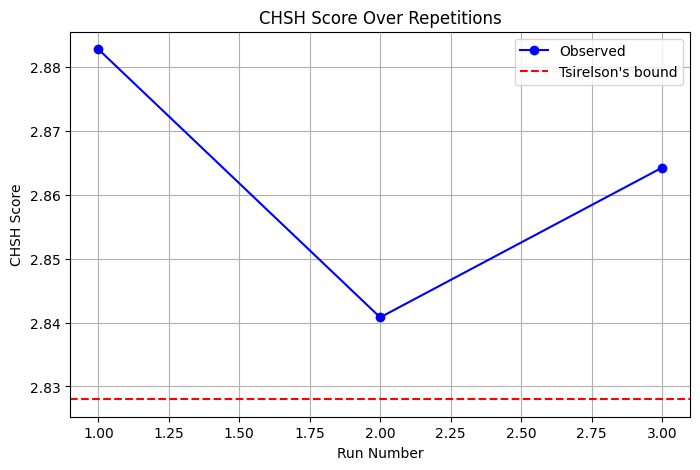

In [ ]:
import matplotlib.pyplot as plt

chsh_scores = [result["figures_of_merit_results"][0]["properties"]["score"] for result in results]

plt.figure(figsize=(8, 5))
plt.plot(
    range(1, len(chsh_scores) + 1),
    chsh_scores,
    marker="o",
    linestyle="-",
    color="b",
    label="Observed",
)

# Add Tsirelson’s bound
tsirelson_bound = 2.828
plt.axhline(tsirelson_bound, color="r", linestyle="--", label="Tsirelson's bound")

plt.title("CHSH Score Over Repetitions")
plt.xlabel("Run Number")
plt.ylabel("CHSH Score")
# plt.ylim(bottom=0)   # start y-axis at 0
# plt.ylim(top=3)
plt.grid(True)
plt.legend()
plt.show()

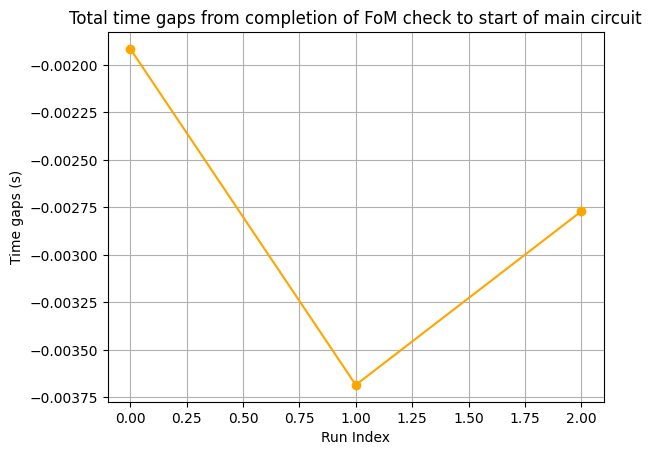

In [ ]:
from datetime import datetime

import matplotlib.pyplot as plt


def parse_utc(s):
    return datetime.fromisoformat(s.replace("Z", "+00:00"))


time_gaps = [
    (
        parse_utc(
            result["figures_of_merit_results"][0]["experiment_result"]["timestamps"]["finished"]
        )
        - parse_utc(result["experiment_result"]["timestamps"]["running"])
    ).total_seconds()
    for result in results
]

plt.figure()
plt.plot(range(len(time_gaps)), time_gaps, marker="o", color="orange")
plt.title("Total time gaps from completion of FoM check to start of main circuit")
plt.xlabel("Run Index")
plt.ylabel("Time gaps (s)")
plt.grid(True)
plt.show()

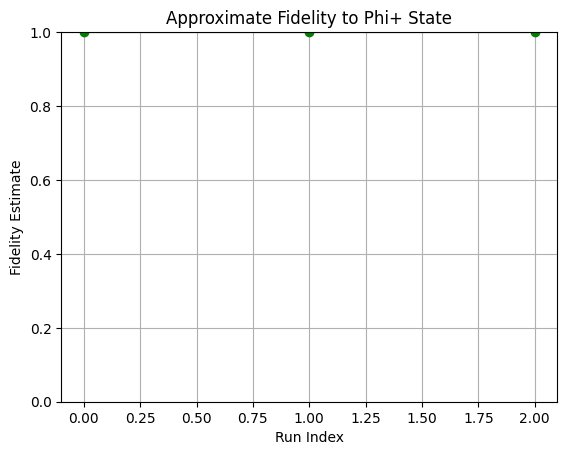

In [ ]:
def phi_plus_fidelity(counts):
    shots = sum(counts.values())
    prob_00 = counts.get("00", 0) / shots
    prob_11 = counts.get("11", 0) / shots
    # For ideal \Phi^+, the off-diagonal terms contribute too, but from counts
    # only, we approximate fidelity
    return prob_00 + prob_11  # coarse classical fidelity estimate


fidelities = [phi_plus_fidelity(result["experiment_result"]["counts"]) for result in results]

plt.figure()
plt.plot(range(len(fidelities)), fidelities, marker="o", color="green")
plt.title("Approximate Fidelity to Phi+ State")
plt.xlabel("Run Index")
plt.ylabel("Fidelity Estimate")
plt.grid(True)
plt.ylim(0, 1)
plt.show()

In [ ]:
# TODO: fix this cell to the new structure of results

import json

import pandas as pd

# Save experiment data in a tabular summary
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
csv_filename = f"experiment_summary_{timestamp}.csv"

df = pd.DataFrame(
    [
        {
            "introspection_created": r.get("introspection", {})
            .get("timestamps", {})
            .get("created"),
            "introspection_running": r.get("introspection", {})
            .get("timestamps", {})
            .get("running"),
            "introspection_finished": r.get("introspection", {})
            .get("timestamps", {})
            .get("finished"),
            "execution_created": r.get("execution", {}).get("timestamps", {}).get("created"),
            "execution_running": r.get("execution", {}).get("timestamps", {}).get("running"),
            "execution_finished": r.get("execution", {}).get("timestamps", {}).get("finished"),
            "entanglement_score": r.get("entanglement_score"),
            "execution_counts": json.dumps(r.get("execution", {}).get("counts"))
            if r.get("execution")
            else None,
        }
        for r in results
    ]
)
df.to_csv(csv_filename, index=False)